<a href="https://colab.research.google.com/github/natalia7244/Machine-Learning-Exercises/blob/main/NLP_Exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Cel projektu

Celem projektu jest zbudowanie systemu analizy sentymentu, który klasyfikuje tweety na podstawie ich treści jako pozytywne, negatywne lub neutralne.

# Importowanie bibliotek i wczytanie danych

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")


train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/twitter_training.csv')
valid_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/twitter_validation.csv')

# Przegląd danych

In [ ]:
print("Wielkość zbioru treningowego:", train_df.shape  )
print("Wielkość zbioru testowegoo:", valid_df.shape )


Wielkość zbioru treningowego: (74681, 4)
Wielkość zbioru testowegoo: (999, 4)


In [ ]:
train_df.head(10)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
5,2402,Borderlands,Positive,So I spent a few hours making something for fu...
6,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
7,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
8,2402,Borderlands,Positive,So I spent a few hours making something for fu...
9,2402,Borderlands,Positive,2010 So I spent a few hours making something f...


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
train_df.columns

Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')

## Dodanie nazw kolumn

In [ ]:
train_df.columns = ['ID', 'Topic', 'Sentiment', 'Tweet']

train_df.head()

,ID,Topic,Sentiment,Tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
valid_df.columns = ['ID', 'Topic', 'Sentiment', 'Tweet']
valid_df.head()

,ID,Topic,Sentiment,Tweet
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


# Przygotowanie danych

## Usuwanie wierszy z brakującymi wartościami

In [ ]:
train_df.isna().sum()

,0
ID,0
Topic,0
Sentiment,0
Tweet,686


In [ ]:
train_df.dropna(inplace=True)
valid_df.dropna(inplace=True)
print("Wielkość zbioru treningowego po usunięciu pustych kolum:", train_df.shape  )

Wielkość zbioru treningowego po usunięciu pustych kolum: (73995, 4)


In [ ]:
#Sprawdzenie (dla pewnosci)
train_df.isna().sum()

,0
ID,0
Topic,0
Sentiment,0
Tweet,0


## Usuwam zbędne kolumny

In [ ]:
train_df = train_df[['Tweet', 'Sentiment']]


## Sprawdzam czy są duplikaty

In [ ]:
train_df['Tweet'].value_counts()

,count
Tweet,
,172
It is not the first time that the EU Commission has taken such a step.,172
"At the same time, despite the fact that there are currently some 100 million people living below the poverty line, most of them do not have access to health services and do not have access to health care, while most of them do not have access to health care.",172
<unk>,133
to,74
...,...
"The most excruciating thing than being blind on social media are the people who constantly ask “if you’re blind how do you tweet?”.. I’m so scared of answering these questions.. [ There is a great google full of answers, just stuff I’ve read. Here they are. RT",1
"The most exhausting thing about being blind on social media is people constantly asking ""if you're blind, how do you tweet?."" I'm so tired of answering these questions.. There's a whole pile full of answers, including what I wrote... Here they are. RT",1
"The hardest thing about being blind on social media is people constantly asking, ""If you're blind, how do you tweet?"" I'm so bored of answering those questions... There's a whole Google full of answers, including everything I've written... Here they are. RT",1


## Sprawdzenie kategorii sentymentów

In [ ]:
label_counts = train_df['Sentiment'].value_counts()
print(label_counts)

Sentiment
Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64


## Usunięcie tweetów "Irrelevant"

In [ ]:
train_df = train_df[train_df['Sentiment'] != 'irrelevant']

## Wykres rozkładu kategorii

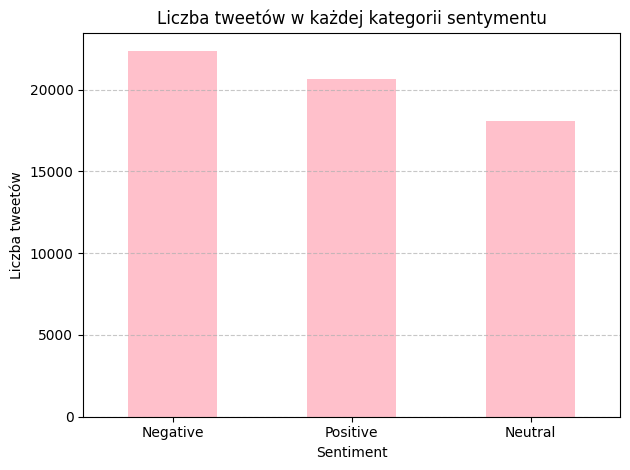

In [ ]:
import matplotlib.pyplot as plt

filtered = train_df[train_df['Sentiment'] != 'Irrelevant']
filtered['Sentiment'].value_counts().plot(kind='bar', color='pink')


plt.title('Liczba tweetów w każdej kategorii sentymentu')
plt.xlabel('Sentiment')
plt.ylabel('Liczba tweetów')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Oczyszczanie danych

## Deklaracja funkcji, która oczyści dane tekstowe


In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS

stopwords = list(STOP_WORDS)
import re
from string import punctuation

def clean_text(text):
    temp = text.lower() #
    temp = re.sub('\d', '', temp)
    temp = re.sub('<[^>]*>', '', temp)
    emojis = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', temp)
    temp = re.sub('[\W]+', ' ', temp) + ' '.join(emojis).replace('-', '')
    temp = re.sub('[{}]'.format(punctuation), '', temp)
    temp = temp.strip()
    return temp
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def text_tokenizer(text):
    text = clean_text(text)
    words_after_stem = [porter.stem(word) for word in text.split()]
    return  [word for word in words_after_stem if word not in stopwords and len(word) > 2] #

## Tokenizacja

In [ ]:
train_df['clean_text'] = train_df['clean_tokens'].apply(lambda x: ' '.join(x))
train_df[['Tweet', 'clean_text']].head(10)


,Tweet,clean_text
0,I am coming to the borders and I will kill you...,come border kill
1,im getting on borderlands and i will kill you ...,borderland kill
2,im coming on borderlands and i will murder you...,come borderland murder
3,im getting on borderlands 2 and i will murder ...,borderland murder
4,im getting into borderlands and i can murder y...,borderland murder
5,So I spent a few hours making something for fu...,spent hour someth fun don know huge borderland...
6,So I spent a couple of hours doing something f...,spent coupl hour someth fun don know huge bord...
7,So I spent a few hours doing something for fun...,spent hour someth fun don know huge borderland...
8,So I spent a few hours making something for fu...,spent hour someth fun don know huge rhandlerr ...
9,2010 So I spent a few hours making something f...,spent hour someth fun don know huge rhandlerr ...


## Wektoryzacja

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_df['clean_text'])
print("Kształt macierzy TF-IDF:", X.shape)


Kształt macierzy TF-IDF: (61120, 18827)


## Zmiana etykiet tekstowych na liczby

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(train_df['Sentiment'])
print(pd.Series(y).value_counts())

0    22358
2    20654
1    18108
Name: count, dtype: int64


##  Uporządkowanie zbioru testowego

In [ ]:
valid_df['clean_tokens'] = valid_df['Tweet'].apply(text_tokenizer)
valid_df['clean_text'] = valid_df['clean_tokens'].apply(lambda x: ' '.join(x)) #tokenizacja
X_valid = vectorizer.transform(valid_df['clean_text']) #wektoryzacja

####
# Usunięcie Irrelevant ze zbioru testowego
from sklearn.preprocessing import LabelEncoder
le2 = LabelEncoder()
y2 = le.fit_transform(valid_df['Sentiment'])
print(pd.Series(y2).value_counts())

1    285
2    277
0    266
Name: count, dtype: int64


# Trenowanie Modelu

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=200)
model.fit(X,y)

LogisticRegression(max_iter=200)

# Ocena modelu

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_valid)

print("Dokładność:", accuracy_score(y2, y_pred))
print("\nRaport klasyfikacji:\n", classification_report(y2, y_pred))


Dokładność: 0.9057971014492754

Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90       266
           1       0.94      0.87      0.91       285
           2       0.89      0.93      0.91       277

    accuracy                           0.91       828
   macro avg       0.91      0.91      0.91       828
weighted avg       0.91      0.91      0.91       828



# Macierz błędów

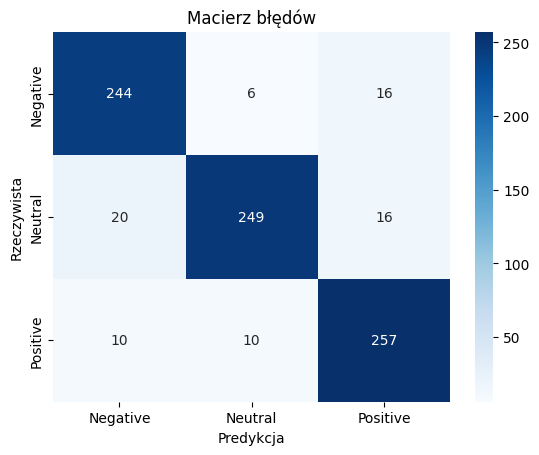

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y2, y_pred)

labels = le.classes_ #Odkodowanie nazw sentymentów

#Wizualizacja
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywista')
plt.title('Macierz błędów')
plt.show()
